In [33]:
import py3Dmol
import plumed

# Setup Process

In [34]:
# Create a cubic water box of 6.07662 nm on each side

!gmx solvate -cs spc216.gro -o box.gro -box 3.07662 3.07662 3.07662

               :-) GROMACS - gmx solvate, 2024.2-conda_forge (-:

Executable:   /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/bin.AVX2_256/gmx
Data prefix:  /home/jiankunzhang1017/miniconda3/envs/gmx_plumed
Working dir:  /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/NaCl Nucleation
Command line:
  gmx solvate -cs spc216.gro -o box.gro -box 3.07662 3.07662 3.07662

Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may

In [35]:
# Generate topology for pure water

!gmx pdb2gmx -f box.gro -o solvated.gro -p topol.top -ff oplsaa -water spce

               :-) GROMACS - gmx pdb2gmx, 2024.2-conda_forge (-:

Executable:   /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/bin.AVX2_256/gmx
Data prefix:  /home/jiankunzhang1017/miniconda3/envs/gmx_plumed
Working dir:  /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/NaCl Nucleation
Command line:
  gmx pdb2gmx -f box.gro -o solvated.gro -p topol.top -ff oplsaa -water spce

Using the Oplsaa force field in directory oplsaa.ff

going to rename oplsaa.ff/aminoacids.r2b
Opening force field file /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/share/gromacs/top/oplsaa.ff/aminoacids.r2b
Reading box.gro...
Read 'Generated by gmx solvate', 2883 atoms

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.

There are 0 chains and 1 blocks of water and 961 residues with 2883 atoms

  chain  #res #atoms

  1 ' '   961   2883  (only water)

No occupancies in box.gro
No occupancies in box.gro
Opening force field file /home/jiankunzhang1017/miniconda3/envs/gmx

In [36]:
# Prepare minimal .tpr for adding ions

ions_mdp = """
integrator    = steep
emtol         = 1000.0
emstep        = 0.01
nsteps        = 500
cutoff-scheme = Verlet
ns_type       = grid
coulombtype   = PME
rcoulomb      = 1.0
rvdw          = 1.0
pme_order     = 4
fourierspacing= 0.12
constraints   = none
pbc           = xyz
nstlog        = 0
nstenergy     = 0
nstxout       = 0
nstvout       = 0
"""

with open("ions.mdp", "w") as f:
    f.write(ions_mdp)

ions_itp = """[ atomtypes ]
; name  bond_type  mass     charge  ptype  sigma(nm) epsilon(kJ/mol)
NA      NA        22.99     1.0     A      0.2436    0.00277
CL      CL        35.45    -1.0     A      0.4400    0.1000

[ atoms ]
; nr  type  resnr  resid  atom  cgnr  charge  mass
1    NA     1     NA     NA     1    1.0    22.99
2    CL     1     CL     CL     2   -1.0    35.45
"""

with open("ions.itp", "w") as f:
    f.write(ions_itp)

!gmx grompp -f ions.mdp -c box.gro -p topol.top -o ions.tpr -maxwarn 2

                :-) GROMACS - gmx grompp, 2024.2-conda_forge (-:

Executable:   /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/bin.AVX2_256/gmx
Data prefix:  /home/jiankunzhang1017/miniconda3/envs/gmx_plumed
Working dir:  /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/NaCl Nucleation
Command line:
  gmx grompp -f ions.mdp -c box.gro -p topol.top -o ions.tpr -maxwarn 2

Ignoring obsolete mdp entry 'ns_type'
Setting the LD random seed to -335610113

Generated 330891 of the 330891 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'
Analysing residue names:
There are:   961      Water residues
Number of degrees of freedom in T-Coupling group rest is 5763.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

The largest distance between excluded atoms is 0.164 nm between atom 1904 and 1905
Calculating fourier

In [37]:
# Add ions (Na+, Cl-) according to Joung–Cheatham parameters
!printf "SOL\n" | gmx genion -s ions.tpr -o ions.gro -p topol.top -pname NA -nname CL -np 150 -nn 150 -rmin 0

# Optional: Write system to PDB for inspection
!gmx editconf -f ions.gro -o system.pdb

                :-) GROMACS - gmx genion, 2024.2-conda_forge (-:

Executable:   /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/bin.AVX2_256/gmx
Data prefix:  /home/jiankunzhang1017/miniconda3/envs/gmx_plumed
Working dir:  /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/NaCl Nucleation
Command line:
  gmx genion -s ions.tpr -o ions.gro -p topol.top -pname NA -nname CL -np 150 -nn 150 -rmin 0

Reading file ions.tpr, VERSION 2024.2-conda_forge (single precision)
Reading file ions.tpr, VERSION 2024.2-conda_forge (single precision)
Will try to add 150 NA ions and 150 CL ions.
Select a continuous group of solvent molecules
Group     0 (         System) has  2883 elements
Group     1 (          Water) has  2883 elements
Group     2 (            SOL) has  2883 elements
Select a group: Selected 2: 'SOL'
Number of (3-atomic) solvent molecules: 961

Processing topology
Replacing 300 solute molecules in topology file (topol.top)  by 150 NA and 150 CL ions.

Back Off! I just backed up topol.to

# Visualization

In [38]:
with open("system.pdb", "r") as f:
    pdb = f.read()

view = py3Dmol.view(width = 800, height = 800)
view.addModel(pdb, "pdb")

# Set representation and colors
view.setStyle({"resn":"NA"},{"sphere":{"color":"red"}})
view.setStyle({"resn":"CL"},{"sphere":{"color":"lime"}})
view.setStyle({"resn":"SOL"},{"sphere":{"color":"blue"}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Processing

In [39]:
md_mdp = """ 
integrator    = md
dt            = 0.002
nsteps        = 500       ; 1 ps
nstxout       = 0           ; disable old-style coordinate output
nstvout       = 0           ; disable old-style velocity output
nstxout-compressed = 10   ; save compressed coordinates every 2 ps
nstenergy     = 500
nstlog        = 500

; Temperature and pressure coupling
tcoupl        = V-rescale
tc-grps       = System
tau_t         = 0.1
ref_t         = 300

pcoupl        = Parrinello-Rahman
pcoupltype    = isotropic
tau_p         = 2.0
ref_p         = 1.0
compressibility = 4.5e-5

; Electrostatics
coulombtype   = PME
rcoulomb      = 1.0
rvdw          = 1.0

constraints   = h-bonds
pbc           = xyz
"""

with open("md.mdp", "w") as f:
    f.write(md_mdp)

In [40]:
!gmx grompp -f ions.mdp -c ions.gro -p topol.top -o em.tpr -maxwarn 2
!gmx mdrun -deffnm em

!gmx grompp -f md.mdp -c em.gro -p topol.top -o md.tpr -maxwarn 2
!gmx mdrun -deffnm md

                :-) GROMACS - gmx grompp, 2024.2-conda_forge (-:

Executable:   /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/bin.AVX2_256/gmx
Data prefix:  /home/jiankunzhang1017/miniconda3/envs/gmx_plumed
Working dir:  /home/jiankunzhang1017/miniconda3/envs/gmx_plumed/NaCl Nucleation
Command line:
  gmx grompp -f ions.mdp -c ions.gro -p topol.top -o em.tpr -maxwarn 2

Ignoring obsolete mdp entry 'ns_type'
Setting the LD random seed to -537135391

Generated 330891 of the 330891 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 1 bonded neighbours molecule type 'NA'

Excluding 1 bonded neighbours molecule type 'CL'
Analysing residue names:
There are:   661      Water residues
There are:   300        Ion residues
Number of degrees of freedom in T-Coupling group rest is 4863.00
The integrator does not provide a ensemble temperature, there i

# Analysis

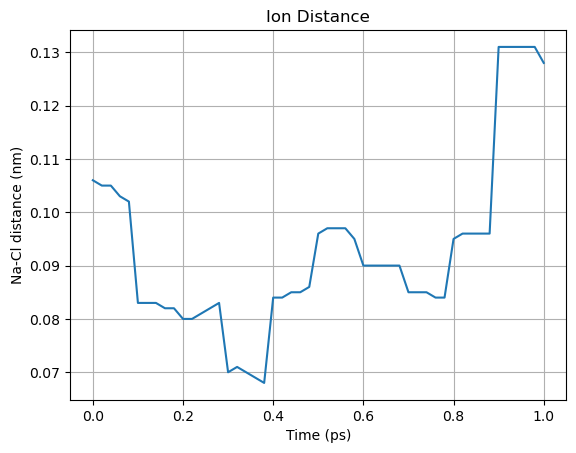

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Load ion distance
dist = np.loadtxt('ion_distance.xvg', comments=['@','#'])
t_dist = dist[:,0]
d = dist[:,1]

# Load energies (time, T, P, Potential) - adjust columns if different
ene = np.loadtxt('md_energies.xvg', comments=['@','#'])
t_ene = ene[:,0]
T = ene[:,1]
P = ene[:,2]
U = ene[:,3]

plt.plot(t_dist, d)
plt.xlabel("Time (ps)")
plt.ylabel("Na-Cl distance (nm)")
plt.title("Ion Distance")
plt.grid()
plt.show()